In [1]:
import sys 
sys.path.append('/Users/zsoltgyure/Documents/private_projects/.venv/lib/python3.10/site-packages/')

In [2]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import tukey_hsd, kruskal, mannwhitneyu, chi2_contingency, ttest_ind, f_oneway
import polars.selectors as cs

In [3]:
import scipy

In [64]:
scipy.__version__

'1.15.3'

In [65]:
sns.__version__

'0.13.2'

In [69]:
import matplotlib
matplotlib.__version__

'3.10.3'

In [19]:
from scipy.stats import chi2_contingency

# Rows = samples, columns = features
table = [
    [79, 95],   # Sample 1
    [264, 57]   # Sample 2
]

chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi² statistic = {chi2:.4f}")
print(f"p-value = {p:.4e}")
print(f"Degrees of freedom = {dof}")
print()

# from scipy.stats import fisher_exact

# # Format: [[a, b], [c, d]]
# table = [[26, 4],
#          [28, 176]]

# odds_ratio, p_value = fisher_exact(table)

# print(f"Fisher's Exact Test:")
# print(f"Odds ratio = {odds_ratio:.4f}")
# print(f"p-value = {p_value:.4e}")

Chi² statistic = 70.2533
p-value = 5.2158e-17
Degrees of freedom = 1



In [10]:
HOME = Path().parent.resolve()
INPUTS = HOME / 'inputs'
OUTPUTS = HOME / 'outputs'
FIGURES = HOME / 'figures'

OUTPUTS.mkdir(exist_ok=True)
FIGURES.mkdir(exist_ok=True)

## Intracellular

In [10]:
variant_dict = {
    'C345': 'WT',
    'C3-1474+611': 'L1474P+G611R',
    'C3-1474': 'L1474P',
    'C3-1661': 'R1661C',
    'C3-611': 'G611R',
}

In [11]:
data = pl.read_csv(INPUTS / 'nanoluc_aggregated_intracellular_2.csv', separator=';')
data

cell_line,m1,m2,m3,m4,rep,exp
str,i64,i64,i64,i64,i64,i64
"""C345""",314,381,416,240,1,1
"""C345""",386,255,330,316,2,1
"""C3-1474""",215,225,248,254,1,1
"""C3-611""",549,702,556,437,1,1
"""C3-1474+611""",342,304,309,282,1,1
…,…,…,…,…,…,…
"""C345""",183,299,234,297,1,3
"""C345""",282,226,416,175,2,3
"""C3-1474""",359,610,410,360,1,3


In [12]:
data_mod = (data
 .melt(
     id_vars=['cell_line', 'rep', 'exp'],
     value_vars=['m1', 'm2', 'm3', 'm4'],
     value_name='signal',
     variable_name='measure'
 )
 .with_columns(
     pl.col('measure').str.replace('m', '').cast(pl.Int64).alias('measure'),
     pl.col('signal').cast(pl.Float64)
 )
)
 
data_mod

/var/folders/kp/td28xw993t7c5zp80ld9wb2w0000gn/T/ipykernel_8467/4291378476.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data_mod = (data


cell_line,rep,exp,measure,signal
str,i64,i64,i64,f64
"""C345""",1,1,1,314.0
"""C345""",2,1,1,386.0
"""C3-1474""",1,1,1,215.0
"""C3-611""",1,1,1,549.0
"""C3-1474+611""",1,1,1,342.0
…,…,…,…,…
"""C345""",1,3,4,297.0
"""C345""",2,3,4,175.0
"""C3-1474""",1,3,4,360.0


In [13]:
intracellular = pl.concat(
    [
        data_mod,
        data_mod
        .group_by(['cell_line','exp'])
        .agg(pl.col('signal').mean())
        .with_columns(
            pl.when(pl.col('cell_line') == 'C345')
            .then(pl.lit('WT'))
            .otherwise(pl.col('cell_line'))
            .alias('sample')
        ).filter(
            pl.col('cell_line') == 'C345'
        ).with_columns(
            pl.lit(0).alias('rep').cast(pl.Int64),
            pl.lit('ref').alias('cell_line'),
            pl.lit(0).alias('measure').cast(pl.Int64)
        )
        .select(data_mod.columns)
    ]
).with_columns(
        [
    (
        pl.col("signal") / 
        pl.col("signal").filter(pl.col("cell_line") == "ref").first() * 100
    ).over("exp")
    .round(2)
    .alias("normalised"),
    pl.col('cell_line').replace(variant_dict, default=pl.col('cell_line')).alias('cell_line'),
    pl.lit('intracellular').alias('type'),
    ]
        ).sort(['cell_line', 'exp', 'rep', 'measure'])

with pl.Config(set_tbl_rows=200):
    print(intracellular)

shape: (63, 7)
┌──────────────┬─────┬─────┬─────────┬────────┬────────────┬───────────────┐
│ cell_line    ┆ rep ┆ exp ┆ measure ┆ signal ┆ normalised ┆ type          │
│ ---          ┆ --- ┆ --- ┆ ---     ┆ ---    ┆ ---        ┆ ---           │
│ str          ┆ i64 ┆ i64 ┆ i64     ┆ f64    ┆ f64        ┆ str           │
╞══════════════╪═════╪═════╪═════════╪════════╪════════════╪═══════════════╡
│ G611R        ┆ 1   ┆ 1   ┆ 1       ┆ 549.0  ┆ 166.49     ┆ intracellular │
│ G611R        ┆ 1   ┆ 1   ┆ 2       ┆ 702.0  ┆ 212.89     ┆ intracellular │
│ G611R        ┆ 1   ┆ 1   ┆ 3       ┆ 556.0  ┆ 168.61     ┆ intracellular │
│ G611R        ┆ 1   ┆ 1   ┆ 4       ┆ 437.0  ┆ 132.52     ┆ intracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 1       ┆ 345.0  ┆ 253.68     ┆ intracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 2       ┆ 441.0  ┆ 324.26     ┆ intracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 3       ┆ 329.0  ┆ 241.91     ┆ intracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 4       ┆ 368.0  ┆ 270.59     ┆ 

/var/folders/kp/td28xw993t7c5zp80ld9wb2w0000gn/T/ipykernel_8467/828119759.py:29: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col('cell_line').replace(variant_dict, default=pl.col('cell_line')).alias('cell_line'),


In [14]:
res = kruskal(
    intracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    intracellular.filter(pl.col('cell_line') == 'L1474P').get_column('normalised').to_list(),
    intracellular.filter(pl.col('cell_line') == 'G611R').get_column('normalised').to_list(),
    intracellular.filter(pl.col('cell_line') == 'L1474P+G611R').get_column('normalised').to_list(),
)
print(res)

KruskalResult(statistic=np.float64(28.813448285444345), pvalue=np.float64(2.4509432877431453e-06))


In [15]:
print(mannwhitneyu(
    intracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    intracellular.filter(pl.col('cell_line') == 'L1474P').get_column('normalised').to_list(),
    method='exact'
))

print(mannwhitneyu(
    intracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    intracellular.filter(pl.col('cell_line') == 'G611R').get_column('normalised').to_list(),
    method='exact'
))

print(mannwhitneyu(
    intracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    intracellular.filter(pl.col('cell_line') == 'L1474P+G611R').get_column('normalised').to_list(),
    method='exact'
))

MannwhitneyuResult(statistic=np.float64(115.5), pvalue=np.float64(0.36127629021432583))
MannwhitneyuResult(statistic=np.float64(2.0), pvalue=np.float64(6.391421689465267e-09))
MannwhitneyuResult(statistic=np.float64(67.5), pvalue=np.float64(0.009818656991332515))


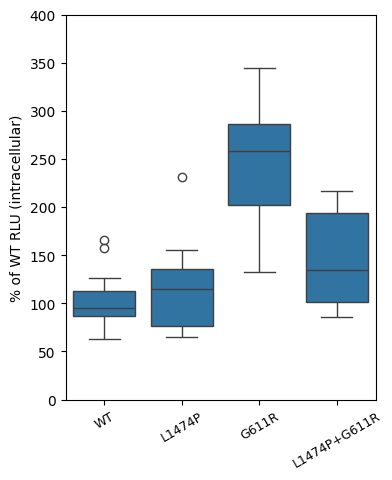

In [16]:
plt.figure(figsize=(4,5))
g = sns.boxplot(
    data=intracellular,
    x = 'cell_line',
    y = 'normalised',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
)
g.set_ylim(0, 400)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "% of WT RLU (intracellular)")
# plt.text('L1474P', 335, 'NS.', horizontalalignment='center')
# plt.text('G611R', 335, 'p=0.002', horizontalalignment='center')
# plt.text('L1474P+G611R', 335, 'NS.', horizontalalignment='center')
plt.savefig(FIGURES / 'intracellular.jpg', 
            dpi=300, 
            bbox_inches = "tight")


## Extracellular

In [17]:
data = pl.read_csv(INPUTS / 'nanoluc_aggregated_extracellular_2.csv', separator=';')
data

cell_line,m1,m2,m3,m4,rep,exp
str,i64,i64,i64,i64,i64,i64
"""C345""",171,190,181,197,1,1
"""C345""",161,199,195,180,2,1
"""C3-1474""",202,185,202,195,1,1
"""C3-611""",138,138,115,99,1,1
"""C3-1474+611""",155,134,144,150,1,1
…,…,…,…,…,…,…
"""C345""",139,118,122,183,1,3
"""C345""",178,136,128,192,2,3
"""C3-1474""",236,202,205,269,1,3


In [18]:
data_mod = (data
 .melt(
     id_vars=['cell_line', 'rep', 'exp'],
     value_vars=['m1', 'm2', 'm3', 'm4'],
     value_name='signal',
     variable_name='measure'
 )
 .with_columns(
     pl.col('measure').str.replace('m', '').cast(pl.Int64).alias('measure'),
     pl.col('signal').cast(pl.Float64)
 )
)
 
data_mod

/var/folders/kp/td28xw993t7c5zp80ld9wb2w0000gn/T/ipykernel_8467/4291378476.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data_mod = (data


cell_line,rep,exp,measure,signal
str,i64,i64,i64,f64
"""C345""",1,1,1,171.0
"""C345""",2,1,1,161.0
"""C3-1474""",1,1,1,202.0
"""C3-611""",1,1,1,138.0
"""C3-1474+611""",1,1,1,155.0
…,…,…,…,…
"""C345""",1,3,4,183.0
"""C345""",2,3,4,192.0
"""C3-1474""",1,3,4,269.0


In [19]:
extracellular = pl.concat(
    [
        data_mod,
        data_mod
        .group_by(['cell_line','exp'])
        .agg(pl.col('signal').mean())
        .with_columns(
            pl.when(pl.col('cell_line') == 'C345')
            .then(pl.lit('WT'))
            .otherwise(pl.col('cell_line'))
            .alias('sample')
        ).filter(
            pl.col('cell_line') == 'C345'
        ).with_columns(
            pl.lit(0).alias('rep').cast(pl.Int64),
            pl.lit('ref').alias('cell_line'),
            pl.lit(0).alias('measure').cast(pl.Int64)
        )
        .select(data_mod.columns)
    ]
).with_columns(
        [
    (
        pl.col("signal") / 
        pl.col("signal").filter(pl.col("cell_line") == "ref").first() * 100
    ).over("exp")
    .round(2)
    .alias("normalised"),
    pl.col('cell_line').replace(variant_dict, default=pl.col('cell_line')).alias('cell_line'),
    pl.lit('extracellular').alias('type'),
    ]
        ).sort(['cell_line', 'exp', 'rep', 'measure'])

with pl.Config(set_tbl_rows=200):
    print(extracellular)

shape: (63, 7)
┌──────────────┬─────┬─────┬─────────┬────────┬────────────┬───────────────┐
│ cell_line    ┆ rep ┆ exp ┆ measure ┆ signal ┆ normalised ┆ type          │
│ ---          ┆ --- ┆ --- ┆ ---     ┆ ---    ┆ ---        ┆ ---           │
│ str          ┆ i64 ┆ i64 ┆ i64     ┆ f64    ┆ f64        ┆ str           │
╞══════════════╪═════╪═════╪═════════╪════════╪════════════╪═══════════════╡
│ G611R        ┆ 1   ┆ 1   ┆ 1       ┆ 138.0  ┆ 74.9       ┆ extracellular │
│ G611R        ┆ 1   ┆ 1   ┆ 2       ┆ 138.0  ┆ 74.9       ┆ extracellular │
│ G611R        ┆ 1   ┆ 1   ┆ 3       ┆ 115.0  ┆ 62.42      ┆ extracellular │
│ G611R        ┆ 1   ┆ 1   ┆ 4       ┆ 99.0   ┆ 53.73      ┆ extracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 1       ┆ 79.0   ┆ 98.9       ┆ extracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 2       ┆ 78.0   ┆ 97.65      ┆ extracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 3       ┆ 61.0   ┆ 76.37      ┆ extracellular │
│ G611R        ┆ 1   ┆ 2   ┆ 4       ┆ 90.0   ┆ 112.68     ┆ 

/var/folders/kp/td28xw993t7c5zp80ld9wb2w0000gn/T/ipykernel_8467/2249986890.py:29: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col('cell_line').replace(variant_dict, default=pl.col('cell_line')).alias('cell_line'),


In [20]:
res = kruskal(
    extracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    extracellular.filter(pl.col('cell_line') == 'L1474P').get_column('normalised').to_list(),
    extracellular.filter(pl.col('cell_line') == 'G611R').get_column('normalised').to_list(),
    extracellular.filter(pl.col('cell_line') == 'L1474P+G611R').get_column('normalised').to_list(),
)
print(res)

KruskalResult(statistic=np.float64(13.22472103332318), pvalue=np.float64(0.004174997166171477))


In [21]:
print(mannwhitneyu(
    extracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    extracellular.filter(pl.col('cell_line') == 'L1474P').get_column('normalised').to_list(),
    method='exact'
))

print(mannwhitneyu(
    extracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    extracellular.filter(pl.col('cell_line') == 'G611R').get_column('normalised').to_list(),
    method='exact'
))

print(mannwhitneyu(
    extracellular.filter(pl.col('cell_line') == 'WT').get_column('normalised').to_list(),
    extracellular.filter(pl.col('cell_line') == 'L1474P+G611R').get_column('normalised').to_list(),
    method='exact'
))

MannwhitneyuResult(statistic=np.float64(68.0), pvalue=np.float64(0.009818656991332515))
MannwhitneyuResult(statistic=np.float64(201.0), pvalue=np.float64(0.057175140213810635))
MannwhitneyuResult(statistic=np.float64(171.5), pvalue=np.float64(0.3791414019759239))


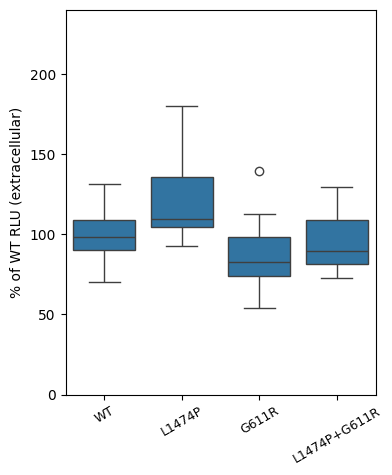

In [22]:
plt.figure(figsize=(4,5))
g = sns.boxplot(
    data=extracellular,
    x = 'cell_line',
    y = 'normalised',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
)
g.set_ylim(0, 240)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "% of WT RLU (extracellular)")
# plt.text('L1474P', 335, 'n.s.', horizontalalignment='center')
# plt.text('G611R', 335, 'n.s', horizontalalignment='center')
# plt.text('L1474P+G611R', 335, 'n.s.', horizontalalignment='center')
plt.savefig(FIGURES / 'extracellular.jpg', 
            dpi=300, 
            bbox_inches = "tight")

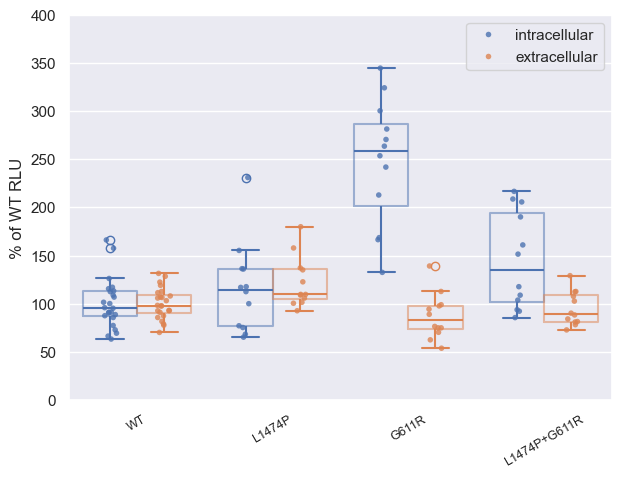

In [23]:
plt.figure(figsize=(7,5))
sns.set_theme()
g = sns.boxplot(
    data=pl.concat([intracellular, extracellular]),
    x = 'cell_line',
    y = 'normalised',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    hue='type',
    fill=False,
    legend=False,
    boxprops=dict(alpha=.5)
)

sns.stripplot(
    data=pl.concat([intracellular, extracellular]),
    x = 'cell_line',
    y = 'normalised',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    hue='type',
    dodge=True,
    alpha=0.8,
    s=4
)

g.set_ylim(0, 400)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "% of WT RLU")
g.legend_.set_title(None)
# plt.text('L1474P', 335, 'n.s.', horizontalalignment='center')
# plt.text('G611R', 335, 'n.s', horizontalalignment='center')
# plt.text('L1474P+G611R', 335, 'n.s.', horizontalalignment='center')
plt.savefig(FIGURES / 'RLU_plots_300dpi.jpg', 
            dpi=300, 
            bbox_inches = "tight")

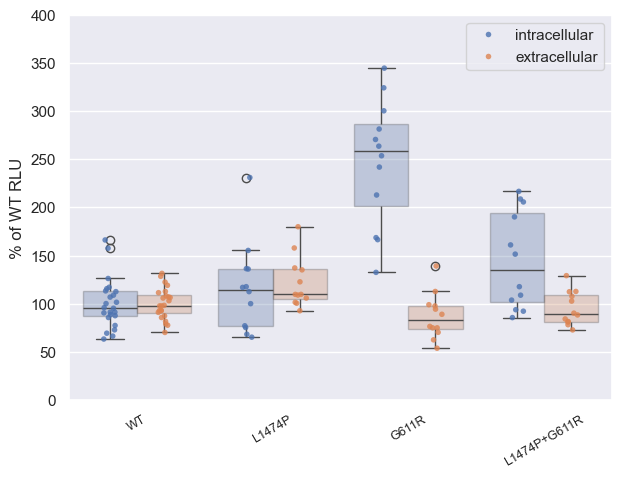

In [24]:
plt.figure(figsize=(7,5))
sns.set_theme()
g = sns.boxplot(
    data=pl.concat([intracellular, extracellular]),
    x = 'cell_line',
    y = 'normalised',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    hue='type',
    legend=False,
    boxprops=dict(alpha=.3)
)

sns.stripplot(
    data=pl.concat([intracellular, extracellular]),
    x = 'cell_line',
    y = 'normalised',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    hue='type',
    dodge=True,
    alpha=0.8,
    s=4
)

g.set_ylim(0, 400)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "% of WT RLU")
g.legend_.set_title(None)
# plt.text('L1474P', 335, 'n.s.', horizontalalignment='center')
# plt.text('G611R', 335, 'n.s', horizontalalignment='center')
# plt.text('L1474P+G611R', 335, 'n.s.', horizontalalignment='center')
plt.savefig(FIGURES / 'RLU_plots_600dpi_filled.jpg', 
            dpi=600, 
            bbox_inches = "tight")

## Residual rate

In [25]:
intracellular

cell_line,rep,exp,measure,signal,normalised,type
str,i64,i64,i64,f64,f64,str
"""G611R""",1,1,1,549.0,166.49,"""intracellular"""
"""G611R""",1,1,2,702.0,212.89,"""intracellular"""
"""G611R""",1,1,3,556.0,168.61,"""intracellular"""
"""G611R""",1,1,4,437.0,132.52,"""intracellular"""
"""G611R""",1,2,1,345.0,253.68,"""intracellular"""
…,…,…,…,…,…,…
"""WT""",2,3,3,416.0,157.58,"""intracellular"""
"""WT""",2,3,4,175.0,66.29,"""intracellular"""
"""ref""",0,1,0,329.75,100.0,"""intracellular"""


In [26]:
residual = (intracellular
 .with_columns(
    pl.col('signal').alias('intra')
    )
 .drop(['type', 'signal', 'normalised'])
 .join(
     other=extracellular
     .with_columns(
         pl.col('signal').alias('extra')
         )
     .drop(['type', 'signal', 'normalised']),
     on=['cell_line', 'rep', 'exp', 'measure']
     )
 .with_columns(
     (pl.col('intra')/(pl.col('intra')+pl.col('extra'))).alias('residual')
 )
 .with_columns(
    (
        pl.col("residual") / 
        pl.col("residual").filter(pl.col("cell_line") == "ref").first() * 100
    ).over("exp")
    .round(2)
    .alias("normalised_residual")
 )
)

with pl.Config(set_tbl_rows=200):
    print(residual)

shape: (63, 8)
┌──────────────┬─────┬─────┬─────────┬────────┬────────┬──────────┬─────────────────────┐
│ cell_line    ┆ rep ┆ exp ┆ measure ┆ intra  ┆ extra  ┆ residual ┆ normalised_residual │
│ ---          ┆ --- ┆ --- ┆ ---     ┆ ---    ┆ ---    ┆ ---      ┆ ---                 │
│ str          ┆ i64 ┆ i64 ┆ i64     ┆ f64    ┆ f64    ┆ f64      ┆ f64                 │
╞══════════════╪═════╪═════╪═════════╪════════╪════════╪══════════╪═════════════════════╡
│ G611R        ┆ 1   ┆ 1   ┆ 1       ┆ 549.0  ┆ 138.0  ┆ 0.799127 ┆ 124.56              │
│ G611R        ┆ 1   ┆ 1   ┆ 2       ┆ 702.0  ┆ 138.0  ┆ 0.835714 ┆ 130.27              │
│ G611R        ┆ 1   ┆ 1   ┆ 3       ┆ 556.0  ┆ 115.0  ┆ 0.828614 ┆ 129.16              │
│ G611R        ┆ 1   ┆ 1   ┆ 4       ┆ 437.0  ┆ 99.0   ┆ 0.815299 ┆ 127.09              │
│ G611R        ┆ 1   ┆ 2   ┆ 1       ┆ 345.0  ┆ 79.0   ┆ 0.813679 ┆ 129.16              │
│ G611R        ┆ 1   ┆ 2   ┆ 2       ┆ 441.0  ┆ 78.0   ┆ 0.849711 ┆ 134.88           

In [27]:
res = kruskal(
    residual.filter(pl.col('cell_line') == 'WT').get_column('normalised_residual').to_list(),
    residual.filter(pl.col('cell_line') == 'L1474P').get_column('normalised_residual').to_list(),
    residual.filter(pl.col('cell_line') == 'G611R').get_column('normalised_residual').to_list(),
    residual.filter(pl.col('cell_line') == 'L1474P+G611R').get_column('normalised_residual').to_list(),
)
print(res)

KruskalResult(statistic=np.float64(35.36751275852807), pvalue=np.float64(1.0187815258935821e-07))


In [28]:
print(mannwhitneyu(
    residual.filter(pl.col('cell_line') == 'WT').get_column('normalised_residual').to_list(),
    residual.filter(pl.col('cell_line') == 'L1474P').get_column('normalised_residual').to_list(),
    method='exact'
))

print(mannwhitneyu(
    residual.filter(pl.col('cell_line') == 'WT').get_column('normalised_residual').to_list(),
    residual.filter(pl.col('cell_line') == 'G611R').get_column('normalised_residual').to_list(),
    method='exact'
))

print(mannwhitneyu(
    residual.filter(pl.col('cell_line') == 'WT').get_column('normalised_residual').to_list(),
    residual.filter(pl.col('cell_line') == 'L1474P+G611R').get_column('normalised_residual').to_list(),
    method='exact'
))

MannwhitneyuResult(statistic=np.float64(172.0), pvalue=np.float64(0.36127629021432583))
MannwhitneyuResult(statistic=np.float64(3.0), pvalue=np.float64(1.1184987956564217e-08))
MannwhitneyuResult(statistic=np.float64(48.0), pvalue=np.float64(0.0008126900399359995))


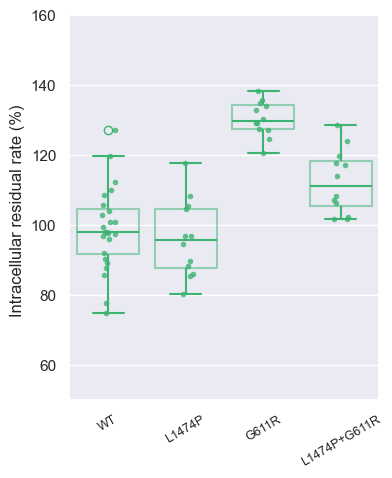

In [29]:
plt.figure(figsize=(4,5))
sns.set_theme()
g = sns.boxplot(
    data=residual,
    x = 'cell_line',
    y = 'normalised_residual',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    fill=False,
    legend=False,
    boxprops=dict(alpha=.5),
    color='mediumseagreen'
)

sns.stripplot(
    data=residual,
    x = 'cell_line',
    y = 'normalised_residual',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    dodge=True,
    alpha=0.8,
    s=4,
    color='mediumseagreen'
)
g.set_ylim(50, 160)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "Intracellular residual rate (%) ")
# plt.text('L1474P', 100, 'n.s.', horizontalalignment='center')
# plt.text('G611R', 100, 'p=0.001', horizontalalignment='center')
# plt.text('L1474P+G611R', 100, 'n.s.', horizontalalignment='center')
plt.savefig(FIGURES / 'residual_ratio_300dpi.jpg', 
            dpi=300, 
            bbox_inches = "tight")

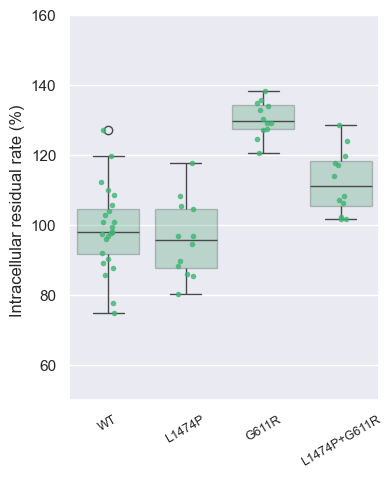

In [30]:
plt.figure(figsize=(4,5))
sns.set_theme()
g = sns.boxplot(
    data=residual,
    x = 'cell_line',
    y = 'normalised_residual',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    legend=False,
    boxprops=dict(alpha=.3),
    color='mediumseagreen'
)

sns.stripplot(
    data=residual,
    x = 'cell_line',
    y = 'normalised_residual',
    order = ['WT', 'L1474P', 'G611R', 'L1474P+G611R'],
    dodge=True,
    alpha=0.8,
    s=4,
    color='mediumseagreen'
)
g.set_ylim(50, 160)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "Intracellular residual rate (%) ")
# plt.text('L1474P', 100, 'n.s.', horizontalalignment='center')
# plt.text('G611R', 100, 'p=0.001', horizontalalignment='center')
# plt.text('L1474P+G611R', 100, 'n.s.', horizontalalignment='center')
plt.savefig(FIGURES / 'residual_ratio_300dpi_filled.jpg', 
            dpi=300, 
            bbox_inches = "tight")

## 2024.10.24

In [31]:
data = pl.read_csv(INPUTS / 'collagen_all_241021_processed.csv')
data.head(5)

genotype,ecrt_percent
str,i64
"""wild type""",83
"""wild type""",76
"""wild type""",81
"""wild type""",72
"""wild type""",70


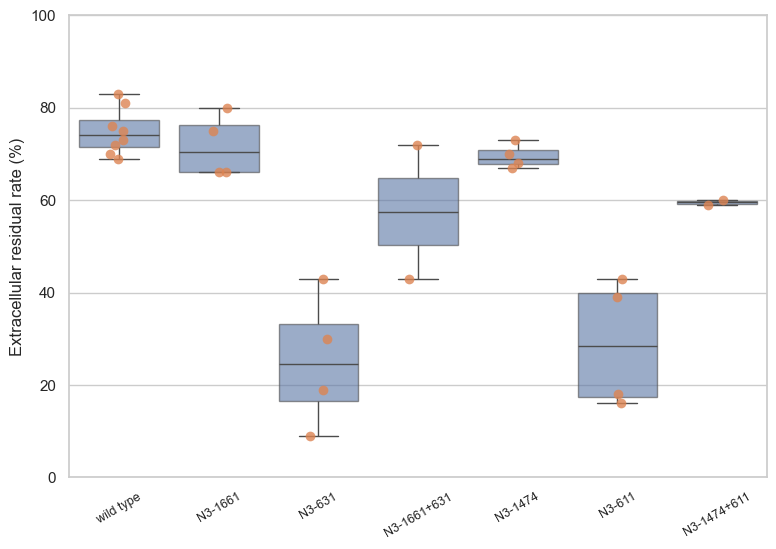

In [32]:
plt.figure(figsize=(9,6))
sns.set_theme(style="whitegrid")
g = sns.boxplot(
    data=data,
    x='genotype',
    y='ecrt_percent',
    legend=False,
    boxprops=dict(alpha=0.6),
)

sns.stripplot(
    data=data,
    x='genotype',
    y='ecrt_percent',
    dodge=True,
    alpha=0.8,
    s=7,

)
g.set_ylim(0, 100)
g.tick_params(axis='x', rotation=30, labelsize=9)
g.set(xlabel ="", ylabel = "Extracellular residual rate (%)")
plt.savefig(FIGURES / 'extracellular_residual_rate_241024.jpg', 
            dpi=300, 
            bbox_inches = "tight")

In [33]:
print(mannwhitneyu(
    data.filter(pl.col('genotype') == 'wild type').get_column('ecrt_percent').to_list(),
    data.filter(pl.col('genotype') == 'N3-1661').get_column('ecrt_percent').to_list(),
    method='exact'
))

print(mannwhitneyu(
    data.filter(pl.col('genotype') == 'wild type').get_column('ecrt_percent').to_list(),
    data.filter(pl.col('genotype') == 'N3-631').get_column('ecrt_percent').to_list(),
    method='exact'
))

print(mannwhitneyu(
    data.filter(pl.col('genotype') == 'wild type').get_column('ecrt_percent').to_list(),
    data.filter(pl.col('genotype') == 'N3-1661+631').get_column('ecrt_percent').to_list(),
    method='exact'
))

print(mannwhitneyu(
    data.filter(pl.col('genotype') == 'wild type').get_column('ecrt_percent').to_list(),
    data.filter(pl.col('genotype') == 'N3-1474').get_column('ecrt_percent').to_list(),
    method='exact'
))


print(mannwhitneyu(
    data.filter(pl.col('genotype') == 'wild type').get_column('ecrt_percent').to_list(),
    data.filter(pl.col('genotype') == 'N3-611').get_column('ecrt_percent').to_list(),
    method='exact'
))

print(mannwhitneyu(
    data.filter(pl.col('genotype') == 'wild type').get_column('ecrt_percent').to_list(),
    data.filter(pl.col('genotype') == 'N3-1474+611').get_column('ecrt_percent').to_list(),
    method='exact'
))

MannwhitneyuResult(statistic=np.float64(21.5), pvalue=np.float64(0.46060606060606063))
MannwhitneyuResult(statistic=np.float64(32.0), pvalue=np.float64(0.00404040404040404))
MannwhitneyuResult(statistic=np.float64(13.5), pvalue=np.float64(0.26666666666666666))
MannwhitneyuResult(statistic=np.float64(27.0), pvalue=np.float64(0.07272727272727274))
MannwhitneyuResult(statistic=np.float64(32.0), pvalue=np.float64(0.00404040404040404))
MannwhitneyuResult(statistic=np.float64(16.0), pvalue=np.float64(0.044444444444444446))


In [40]:
data.get_column('genotype').unique()

genotype
str
"""N3-1661+631"""
"""N3-611"""
"""N3-1661"""
"""N3-1474"""
"""wild type"""
"""N3-631"""
"""N3-1474+611"""


## 2025.05.31.

In [128]:
data = pl.read_csv(INPUTS / 'regi_figures1.csv')
data

type,idx,WT,L1474P,R1661C,G695R,C1665Y,G818R,P1461L,I1330T,G611R,C1548Y,G242E
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""intracellular""",1,49,132,82,124,7,108,70,112,81,8,92
"""intracellular""",2,114,98,7,74,4,100,55,131,32,6,43
"""intracellular""",3,70,115,0,83,13,111,103,136,53,8,63
"""intracellular""",4,102,95,30,87,8,78,78,83,75,5,65
"""intracellular""",5,94,115,23,124,5,109,73,87,78,25,90
…,…,…,…,…,…,…,…,…,…,…,…,…
"""extracellular""",104,105,null,null,null,null,null,null,null,null,null,null
"""extracellular""",105,82,null,null,null,null,null,null,null,null,null,null
"""extracellular""",106,76,null,null,null,null,null,null,null,null,null,null


In [129]:
data = data.with_columns(
    pl.col('idx').cast(pl.String),
).unpivot(
    cs.integer(),
    index=['idx', 'type'],
    variable_name='genotype',
    value_name='value'
).drop_nulls().drop('idx')

In [130]:
custom_palette = [sns.color_palette()[-1], sns.color_palette("husl", 9)[0]]

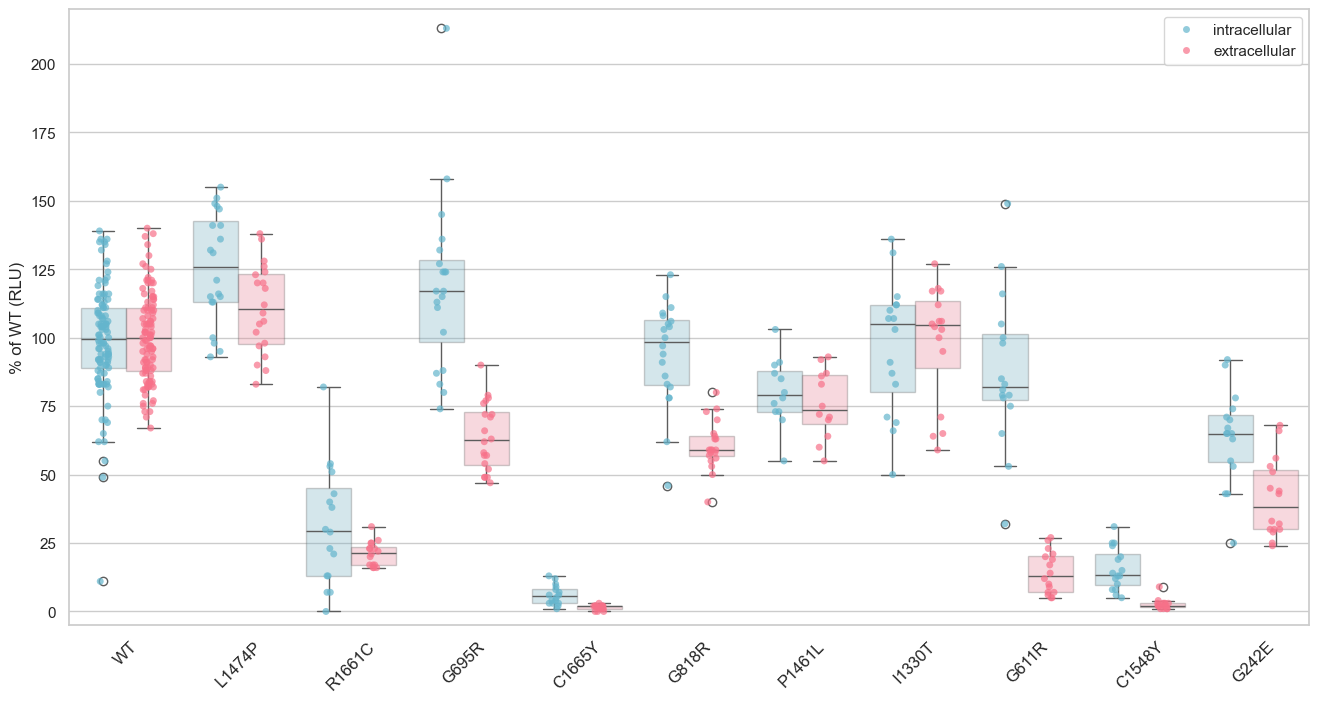

In [131]:
plt.figure(figsize=(16,8))
sns.set_theme(style="whitegrid")
g = sns.boxplot(
    data=data,
    x='genotype',
    y='value',
    hue='type',
    legend=False,
    boxprops=dict(alpha=0.3),
    palette=custom_palette
)

sns.stripplot(
    data=data,
    x='genotype',
    y='value',
    hue='type',
    dodge=True,
    alpha=0.7,
    s=5,
    palette=custom_palette

)
g.legend(title=None)
g.set_ylim(-5, 220)
g.tick_params(axis='x', rotation=45, labelsize=12)
g.set(xlabel ="", ylabel = "% of WT (RLU)")
plt.savefig(FIGURES / '1A_intra_and_extracellular_all.jpg', 
            dpi=300, 
            bbox_inches = "tight")

In [132]:
data = pl.read_csv(INPUTS / 'regi_figures2.csv')

data = data.with_columns(
    pl.col('idx').cast(pl.String),
).unpivot(
    cs.integer(),
    index=['idx', 'type'],
    variable_name='genotype',
    value_name='value'
).drop_nulls().drop('idx')

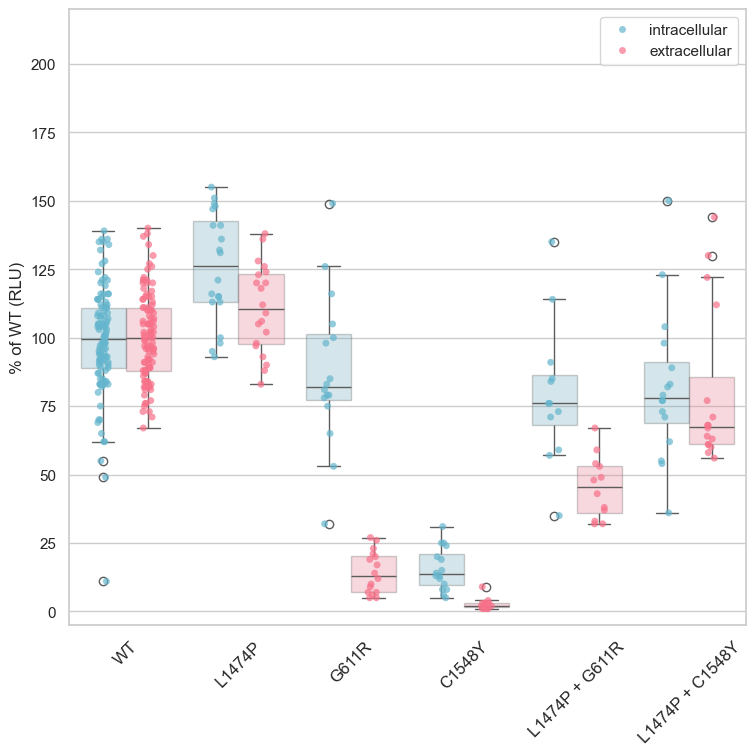

In [133]:
plt.figure(figsize=(6/11*16,8))
sns.set_theme(style="whitegrid")
g = sns.boxplot(
    data=data,
    x='genotype',
    y='value',
    hue='type',
    legend=False,
    boxprops=dict(alpha=0.3),
    palette=custom_palette
)
sns.stripplot(
    data=data,
    x='genotype',
    y='value',
    hue='type',
    dodge=True,
    alpha=0.7,
    s=5,
    palette=custom_palette

)
g.legend(title=None)
g.set_ylim(-5, 220)
g.tick_params(axis='x', rotation=45, labelsize=12)
g.set(xlabel ="", ylabel = "% of WT (RLU)")
plt.savefig(FIGURES / '2A_intra_and_extracellular_co_expression.jpg', 
            dpi=300, 
            bbox_inches = "tight")

In [134]:
data = pl.read_csv(INPUTS / 'secration_all.csv')

data = data.with_columns(
    pl.col('idx').cast(pl.String),
).unpivot(
    cs.integer(),
    index=['idx'],
    variable_name='genotype',
    value_name='value'
).drop_nulls(
    ).drop(
        'idx'
        ).with_columns(
            pl.when(
                pl.col('genotype') == 'WT'
            ).then(
                pl.lit('wild type')
                ).when(
                pl.col('genotype').is_in(
                    ['L1474P', 'R1661C', 'G695R', 'C1665Y', 'G818R', 'P1461L', 'I1330T']
                )).then(
                    pl.lit('IP variant')
                ).otherwise(
                    pl.lit('CP variant')
                ).alias('mutation_type')
        )

data

genotype,value,mutation_type
str,i64,str
"""WT""",92,"""wild type"""
"""WT""",78,"""wild type"""
"""WT""",85,"""wild type"""
"""WT""",78,"""wild type"""
"""WT""",79,"""wild type"""
…,…,…
"""G242E""",68,"""CP variant"""
"""G242E""",72,"""CP variant"""
"""G242E""",69,"""CP variant"""


In [135]:
custom_palette = [
    sns.color_palette("Set2")[-1], 
    sns.color_palette("Set2")[0],
    sns.color_palette("Set2")[-3]
    ]

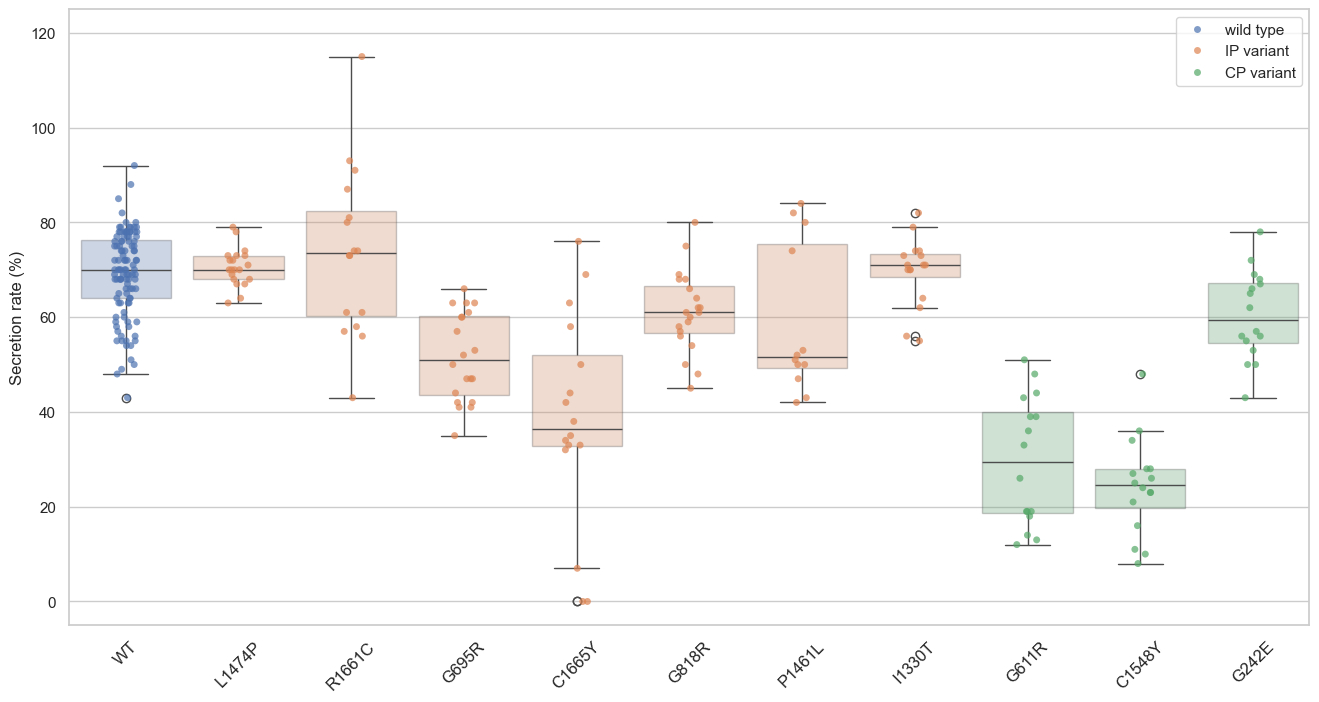

In [136]:
plt.figure(figsize=(16,8))
sns.set_theme(style="whitegrid")
g = sns.boxplot(
    data=data,
    x='genotype',
    y='value',
    hue='mutation_type',
    legend=False,
    boxprops=dict(alpha=0.3),
)

sns.stripplot(
    data=data,
    x='genotype',
    y='value',
    hue='mutation_type',
    dodge=False,
    alpha=0.7,
    s=5,

)
g.legend(title=None)
g.set_ylim(-5, 125)
g.tick_params(axis='x', rotation=45, labelsize=12)
g.set(xlabel ="", ylabel = "Secretion rate (%)")
plt.savefig(FIGURES / '1B_secretion_rate.jpg', 
            dpi=300, 
            bbox_inches = "tight")

In [137]:
data = pl.read_csv(INPUTS / 'secration_rate_coexpression.csv')

data = data.with_columns(
    pl.col('idx').cast(pl.String),
).unpivot(
    cs.integer(),
    index=['idx'],
    variable_name='genotype',
    value_name='value'
).drop_nulls(
    ).drop(
        'idx'
        ).with_columns(
            pl.when(
                pl.col('genotype') == 'WT'
            ).then(
                pl.lit('wild type')
                ).when(
                pl.col('genotype').is_in(
                    ['L1474P']
                )).then(
                    pl.lit('IP variant')
                ).when(
                    pl.col('genotype').is_in(
                        ['G611R', 'C1548Y']
                    )).then(
                        pl.lit('CP variant')
                        ).otherwise(
                        pl.lit('co-expressed')
                            ).alias('mutation_type')
        )

data

genotype,value,mutation_type
str,i64,str
"""WT""",92,"""wild type"""
"""WT""",78,"""wild type"""
"""WT""",85,"""wild type"""
"""WT""",78,"""wild type"""
"""WT""",79,"""wild type"""
…,…,…
"""L1474P+C1548Y""",64,"""co-expressed"""
"""L1474P+C1548Y""",62,"""co-expressed"""
"""L1474P+C1548Y""",61,"""co-expressed"""


In [138]:
custom_palette = [
    sns.color_palette()[0], 
    sns.color_palette()[1],
    sns.color_palette()[2],
    sns.hls_palette()[4]
    ]

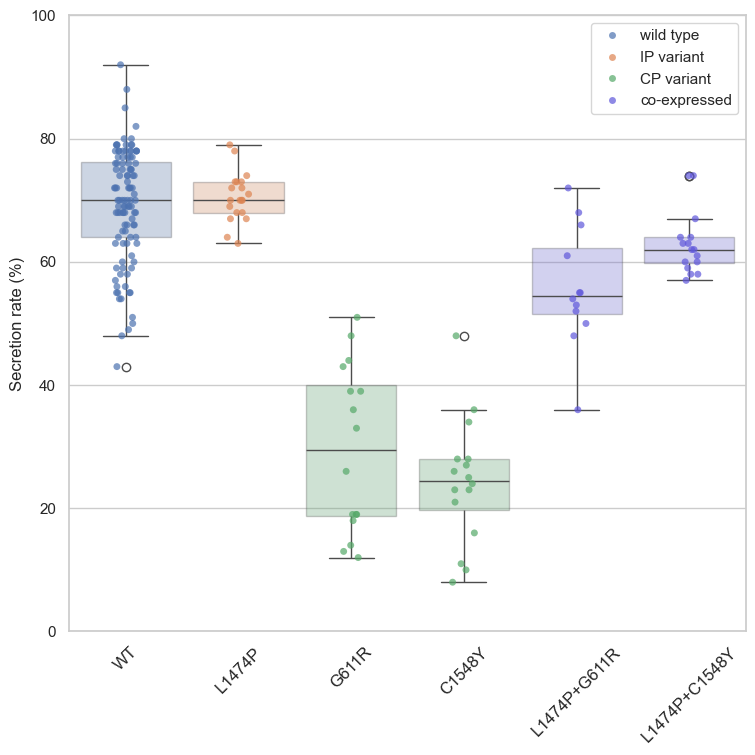

In [139]:
plt.figure(figsize=(6/11*16,8))
sns.set_theme(style="whitegrid")
g = sns.boxplot(
    data=data,
    x='genotype',
    y='value',
    hue='mutation_type',
    legend=False,
    boxprops=dict(alpha=0.3),
    palette=custom_palette
)

sns.stripplot(
    data=data,
    x='genotype',
    y='value',
    hue='mutation_type',
    dodge=False,
    alpha=0.7,
    s=5,
    palette=custom_palette
)
g.legend(title=None)
g.set_ylim(0, 100)
g.tick_params(axis='x', rotation=45, labelsize=12)
g.set(xlabel ="", ylabel = "Secretion rate (%)")
plt.savefig(FIGURES / '2B_secretion_rate_coexpression.jpg', 
            dpi=300, 
            bbox_inches = "tight")

# 2025.06.16.

In [4]:
HOME = Path().parent.resolve()
INPUTS = HOME / 'inputs'
OUTPUTS = HOME / 'outputs'
FIGURES = HOME / 'figures'

OUTPUTS.mkdir(exist_ok=True)
FIGURES.mkdir(exist_ok=True)

In [5]:
def form(data: pl.DataFrame) -> pl.DataFrame:
    return data.with_columns(
        pl.col('idx').cast(pl.String),
        ).unpivot(
            cs.integer(),
            index=['idx'],
            variable_name='genotype',
            value_name='value'
        ).drop_nulls(
            ).drop(
                'idx'
                )
            
def plot(
    data: pl.DataFrame,
    y_label: str,
    title: str,
    figsize: tuple = (16, 8),
    hue: str = None,
    hue_order: list = None,
    color: str = None,
    custom_palette: list = None,
    ) -> None:

    max_value = data.get_column('value').max()
    upper_limit = (max_value // 20 + 1) * 20
    min_value = data.get_column('value').min()
    
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    g = sns.boxplot(
        data=data,
        x='genotype',
        y='value',
        hue=hue,
        hue_order=hue_order,
        color=color,
        palette=custom_palette,
        legend=False,
        boxprops=dict(alpha=0.3),
        showfliers=False
    )

    sns.stripplot(
        data=data,
        x='genotype',
        y='value',
        hue=hue,
        dodge=False,
        color=color,
        legend=False,
        palette=custom_palette,
        hue_order=hue_order,
        alpha=0.7,
        s=5,

    )
    # g.legend(title=None)
    g.set_ylim(0 if min_value > 0 else min_value-1, upper_limit)   
    g.set_yticks(range(0, upper_limit + 1, 20))
    g.set_yticks(range(0, upper_limit + 1, 5), minor=True)
     
    g.tick_params(axis='x', rotation=45, labelsize=12)
    g.set(xlabel ="", ylabel = y_label)
    plt.xlabel('', fontsize=16)
    plt.ylabel(y_label, fontsize=20)

    g.tick_params(axis='both', labelsize=16)
    # plt.title(title, fontdict={'fontsize': 24, 'fontweight': 'bold'})
    plt.savefig(FIGURES / f'{title}.jpg', 
                dpi=300, 
                bbox_inches = "tight")
    plt.show()

In [6]:
intra = form(pl.read_csv(INPUTS / '20250616_intra.csv').with_columns(pl.lit('intracellular').alias('type')))
extra = form(pl.read_csv(INPUTS / '20250616_extra.csv').with_columns(pl.lit('extracellular').alias('type')))
rate = form(pl.read_csv(INPUTS / '20250616_rate.csv').with_columns(pl.lit('secretion').alias('type')))


In [7]:
rate = rate.with_columns(
            pl.when(
                pl.col('genotype') == 'wt'
            ).then(
                pl.lit('wild type')
                ).when(
                pl.col('genotype').is_in(
                    ['G695R', 'G818R', 'L1474P', 'R1661C']
                )).then(
                    pl.lit('IP variant')
                ).when(
                    pl.col('genotype').is_in(
                        ['G611R', 'C1548Y', 'G242E']
                    )).then(
                        pl.lit('CP variant')
                        ).otherwise(
                        pl.lit('co-expressed')
                            ).alias('mutation_type')
        )

extra = extra.with_columns(
            pl.when(
                pl.col('genotype') == 'wt'
            ).then(
                pl.lit('wild type')
                ).when(
                pl.col('genotype').is_in(
                    ['G695R', 'G818R', 'L1474P', 'R1661C']
                )).then(
                    pl.lit('IP variant')
                ).when(
                    pl.col('genotype').is_in(
                        ['G611R', 'C1548Y', 'G242E']
                    )).then(
                        pl.lit('CP variant')
                        ).otherwise(
                        pl.lit('co-expressed')
                            ).alias('mutation_type')
        )

intra = intra.with_columns(
            pl.when(
                pl.col('genotype') == 'wt'
            ).then(
                pl.lit('wild type')
                ).when(
                pl.col('genotype').is_in(
                    ['G695R', 'G818R', 'L1474P', 'R1661C']
                )).then(
                    pl.lit('IP variant')
                ).when(
                    pl.col('genotype').is_in(
                        ['G611R', 'C1548Y', 'G242E']
                    )).then(
                        pl.lit('CP variant')
                        ).otherwise(
                        pl.lit('co-expressed')
                            ).alias('mutation_type')
        )

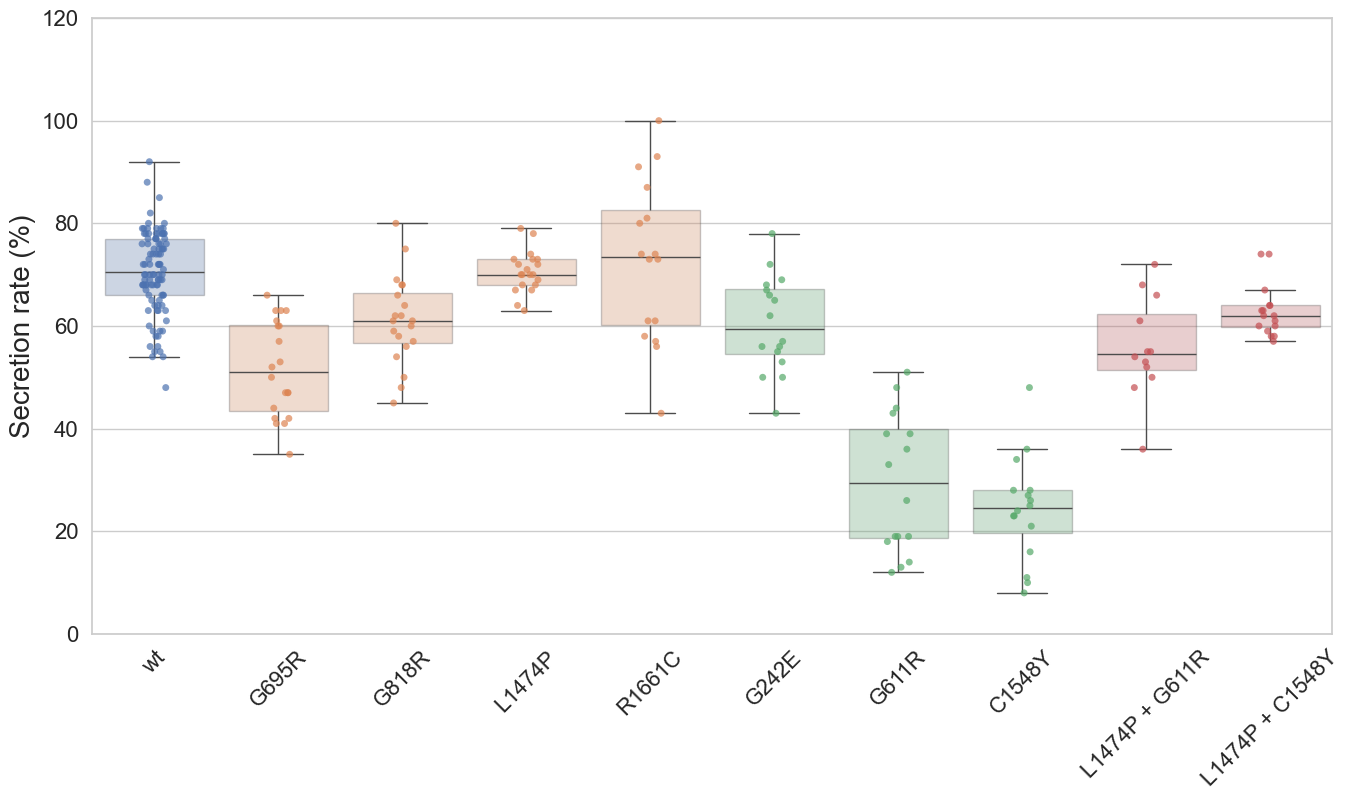

In [8]:
plot(
    rate,
    y_label='Secretion rate (%)',
    title='20250618_secretion_rate',
    hue_order=['wild type', 'IP variant', 'CP variant', 'co-expressed'],
    hue='mutation_type',
)

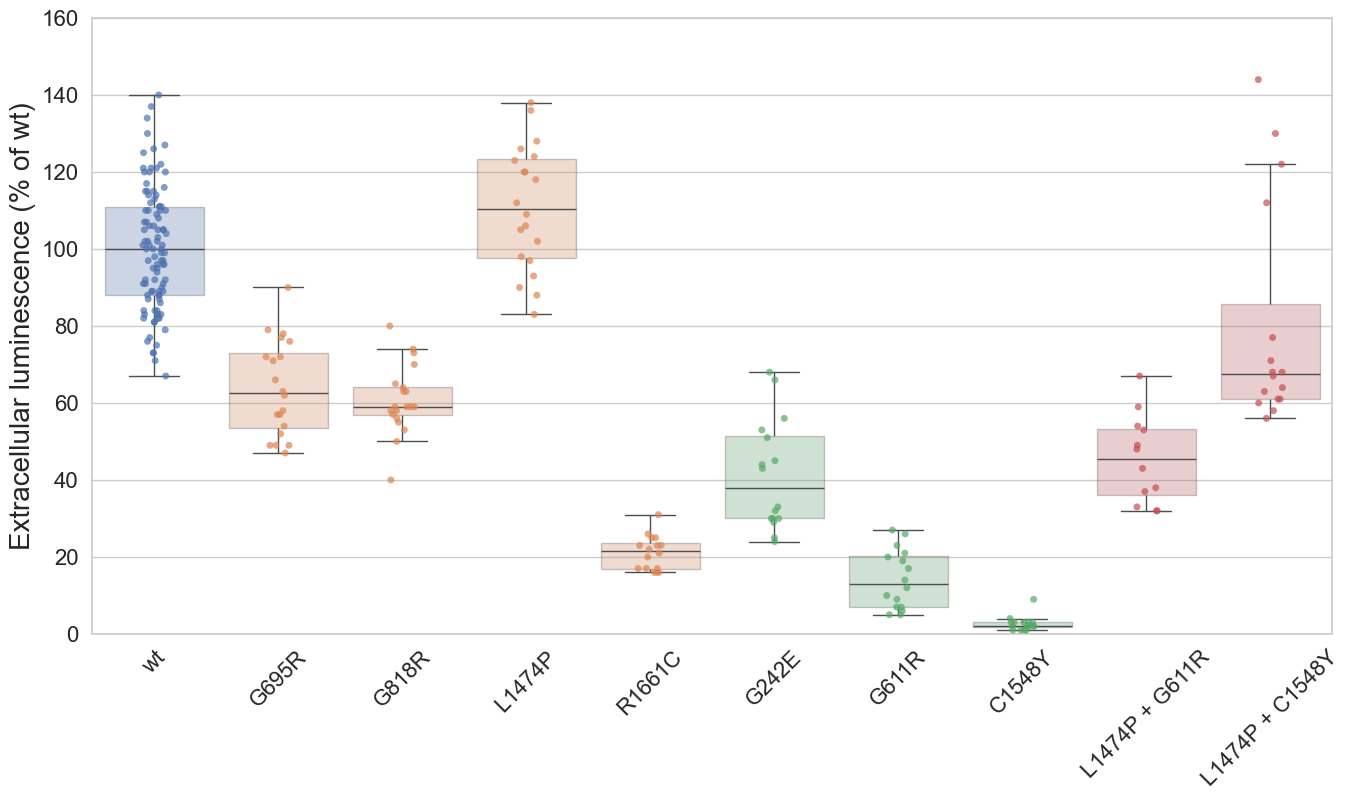

In [9]:
plot(
    extra,
    y_label='Extracellular luminescence (% of wt)',
    title='20250618_extracellular',
    hue_order=['wild type', 'IP variant', 'CP variant', 'co-expressed'],
    hue='mutation_type',
)

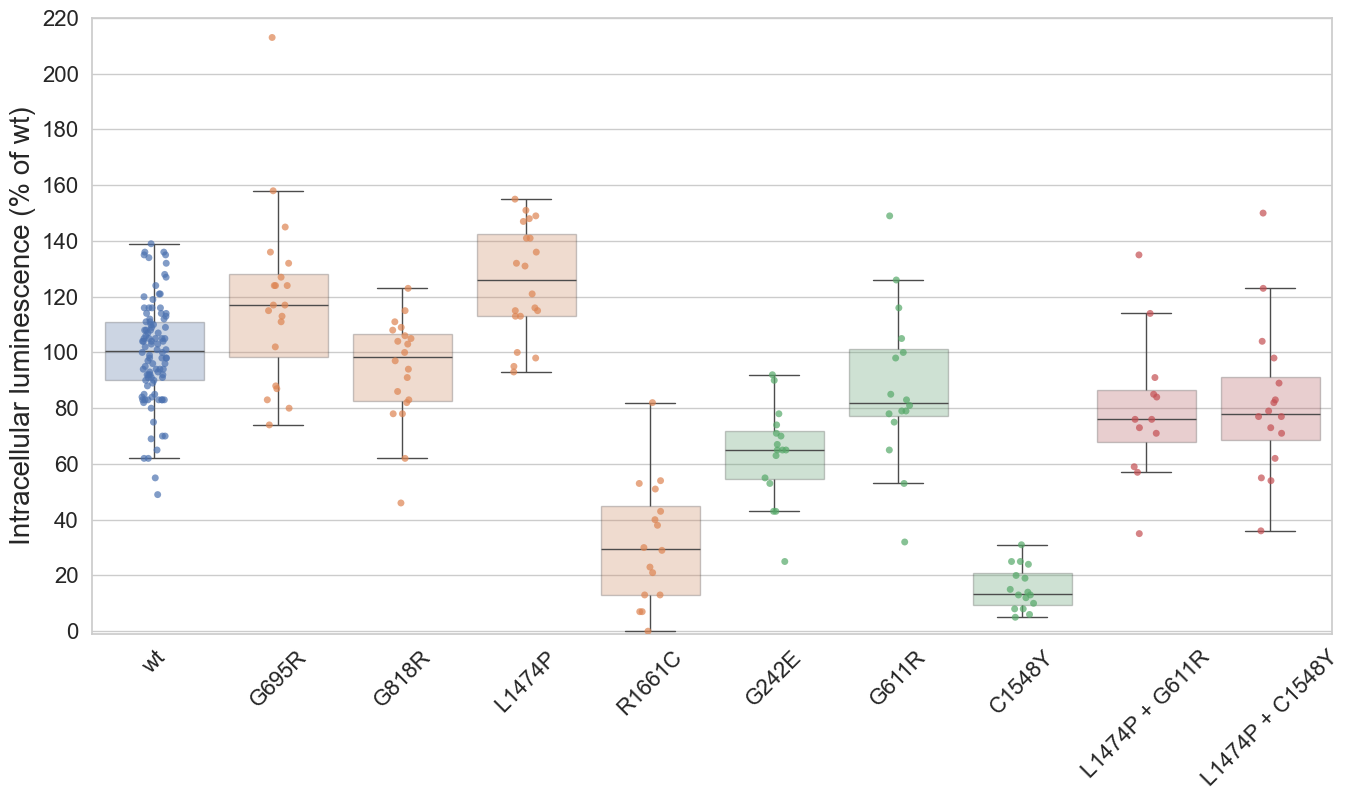

In [18]:
plot(
    intra,
    y_label='Intracellular luminescence (% of wt)',
    title='20250618_intracellular',
    hue_order=['wild type', 'IP variant', 'CP variant', 'co-expressed'],
    hue='mutation_type',
)

In [16]:
def run_statistics(
    data: pl.DataFrame,
    group_by: str,
    title: str
    ) -> None:
    
    print(f"Statistics for {title}")
    
    results = []
    
    groups = data.get_column(group_by).unique().to_list()

    for group1 in groups:
        for group2 in groups:
            mw = (mannwhitneyu(
                data.filter(pl.col(group_by) == group1).get_column('value').to_list(),
                data.filter(pl.col(group_by) == group2).get_column('value').to_list(),
                method='exact'
            ))
            results.append({
                'reference': group1,
                'compare': group2,
                'statistic': mw.statistic,
                'pvalue': mw.pvalue
            })
            
            res = kruskal(
                data.filter(pl.col(group_by) == group1).get_column('value').to_list(),
                data.filter(pl.col(group_by) == group2).get_column('value').to_list(),
            )
            print(f"Kruskal-Wallis test: H={res.statistic:.4f}, p-value={res.pvalue:.4e}")
            print()
            
            results.append({
                'reference': group1,
                'compare': group2,
                'kruskal_statistic': res.statistic,
                'kruskal_pvalue': res.pvalue
            })
            
    result_df = pl.from_dicts(results)
    result_df.write_csv(OUTPUTS / f'{title}_statistics.csv')
            


In [17]:
run_statistics(data=rate, group_by='genotype', title="secretion_rate_genotype")
run_statistics(data=extra, group_by='genotype', title="extracellular_genotype")
run_statistics(data=intra, group_by='genotype', title="intracellular_genotype")

run_statistics(data=rate, group_by='mutation_type', title="secretion_rate_mutation_type")
run_statistics(data=extra, group_by='mutation_type', title="extracellular_mutation_type")
run_statistics(data=intra, group_by='mutation_type', title="intracellular_mutation_type")

Statistics for secretion_rate_genotype
Kruskal-Wallis test: H=0.0000, p-value=1.0000e+00

Kruskal-Wallis test: H=10.1902, p-value=1.4119e-03

Kruskal-Wallis test: H=0.4487, p-value=5.0293e-01

Kruskal-Wallis test: H=23.3197, p-value=1.3718e-06

Kruskal-Wallis test: H=5.0806, p-value=2.4195e-02

Kruskal-Wallis test: H=23.3069, p-value=1.3810e-06

Kruskal-Wallis test: H=2.4572, p-value=1.1699e-01

Kruskal-Wallis test: H=14.7130, p-value=1.2518e-04

Kruskal-Wallis test: H=0.6891, p-value=4.0646e-01

Kruskal-Wallis test: H=14.1760, p-value=1.6648e-04

Kruskal-Wallis test: H=10.1902, p-value=1.4119e-03

Kruskal-Wallis test: H=0.0000, p-value=1.0000e+00

Kruskal-Wallis test: H=7.7041, p-value=5.5095e-03

Kruskal-Wallis test: H=16.5121, p-value=4.8342e-05

Kruskal-Wallis test: H=1.6054, p-value=2.0514e-01

Kruskal-Wallis test: H=22.8423, p-value=1.7586e-06

Kruskal-Wallis test: H=13.0867, p-value=2.9741e-04

Kruskal-Wallis test: H=38.3495, p-value=5.9143e-10

Kruskal-Wallis test: H=6.2608, p-

In [14]:
genotypes = rate.get_column('genotype').unique().to_list()
genotypes.remove('wt')

res = kruskal(
    rate.filter(pl.col('genotype') == 'wt').get_column('value').to_list(),
    *[
        rate.filter(pl.col('genotype') == gt).get_column('value').to_list()
        for gt in genotypes if gt != 'wt'
    ]
)
print(f'Kruskal-Wallis test for secretion rate genotypes: {res}')
genotypes = extra.get_column('genotype').unique().to_list()
genotypes.remove('wt')

res = kruskal(
    extra.filter(pl.col('genotype') == 'wt').get_column('value').to_list(),
    *[
        extra.filter(pl.col('genotype') == gt).get_column('value').to_list()
        for gt in genotypes if gt != 'wt'
    ]
)
print(f'Kruskal-Wallis test for extracellular genotypes: {res}')
genotypes = intra.get_column('genotype').unique().to_list()
genotypes.remove('wt')

res = kruskal(
    intra.filter(pl.col('genotype') == 'wt').get_column('value').to_list(),
    *[
        intra.filter(pl.col('genotype') == gt).get_column('value').to_list()
        for gt in genotypes if gt != 'wt'
    ]
)
print(f'Kruskal-Wallis test for intracellular genotypes: {res}')

Kruskal-Wallis test for secretion rate genotypes: KruskalResult(statistic=142.4446778775237, pvalue=3.225570747461422e-26)
Kruskal-Wallis test for extracellular genotypes: KruskalResult(statistic=206.01668539094106, pvalue=1.8126620568804573e-39)
Kruskal-Wallis test for intracellular genotypes: KruskalResult(statistic=137.787465619932, pvalue=2.951997240942958e-25)


In [15]:
from scipy.stats import fisher_exact

In [6]:
fisher_exact(
    [
        [26, 3],
        [24, 74]
    ]
)

SignificanceResult(statistic=26.72222222222222, pvalue=2.549297100028261e-10)

## 2025.06.26.

In [9]:
intra_extra = form(pl.read_csv(INPUTS / '20250616_intra.csv').with_columns(pl.lit('intracellular').alias('type')))

intra_extra = intra_extra.with_columns(
            pl.when(
                pl.col('genotype') == 'wt'
            ).then(
                pl.lit('wild type')
                ).when(
                pl.col('genotype').is_in(
                    ['G695R', 'G818R', 'L1474P', 'R1661C']
                )).then(
                    pl.lit('IP variant')
                ).when(
                    pl.col('genotype').is_in(
                        ['G611R', 'C1548Y', 'G242E']
                    )).then(
                        pl.lit('CP variant')
                        ).otherwise(
                        pl.lit('co-expressed')
                            ).alias('mutation_type')
        )

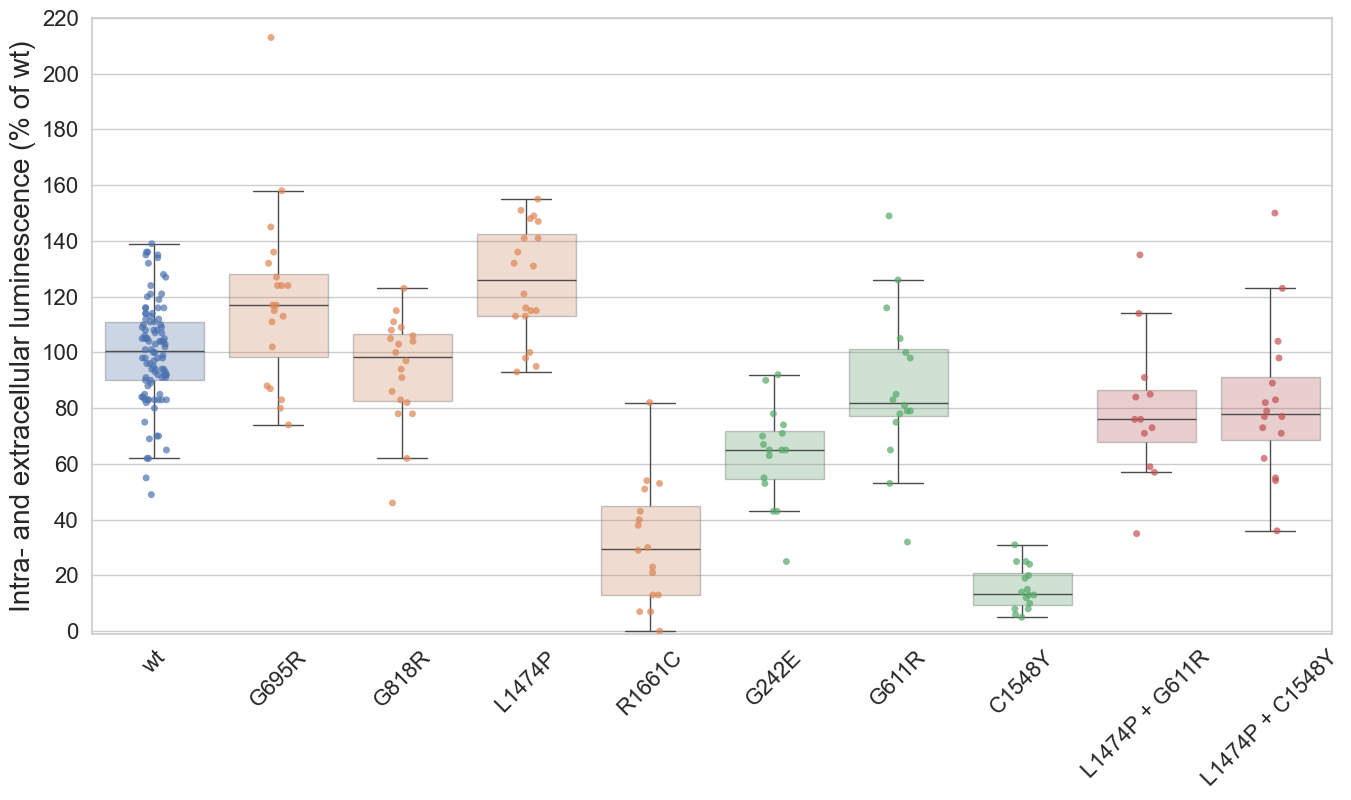

In [15]:
plot(
    intra_extra,
    y_label='Intra- and extracellular luminescence (% of wt)',
    title='20250626_intra_extra',
    hue_order=['wild type', 'IP variant', 'CP variant', 'co-expressed'],
    hue='mutation_type',
)

In [19]:
run_statistics(data=intra_extra, group_by='genotype', title="intra_extra_genotype")
run_statistics(data=intra_extra, group_by='mutation_type', title="intra_extra_mutation_type")

Statistics for intra_extra_genotype
Statistics for intra_extra_mutation_type
